# Alx-movie-recommendation-project-2024

## Problem Statement

Movie recommendations are an important part of online streaming services, but with so many options available, it can be difficult for users to find movies that match their preferences.


### Challenge Description

In today's technology-driven world, recommender systems play a vital role in helping individuals make informed choices about the content they engage with daily. This is especially important for movie recommendations, where intelligent algorithms can help viewers discover excellent titles from a vast selection of options.

It's not just a guess drawn out of a hat; there's an algorithm behind it.

With this context,

The Kaggle challenge is to,
Construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

### Objectives:

1. Develop a collaborative filtering model using the Surprise package to predict movie ratings for users based on the preferences of similar users.
2. Preprocess and clean the dataset to ensure accurate and reliable results.
3. Evaluate the performance of the model using RMSE and other metrics to determine its accuracy and effectiveness.
4. Identify potential areas for improvement in the model and suggest future work to enhance its performance.

## Data Overview

The dataset used in this project comprises several million 5-star ratings collected from users of the MovieLens online movie recommendation service. This dataset has been widely employed by both industry and academic researchers to enhance the effectiveness of explicit recommendation systems.

### Supplied Files

genome_scores.csv - a score mapping the strength between movies and tag-related properties.

genome_tags.csv - user assigned tags for genome-related scores

imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.

links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.

sample_submission.csv - Sample of the submission format for the hackathon.

tags.csv - User assigned for the movies within the dataset.

test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.

train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

### Total Data Size: 848MB

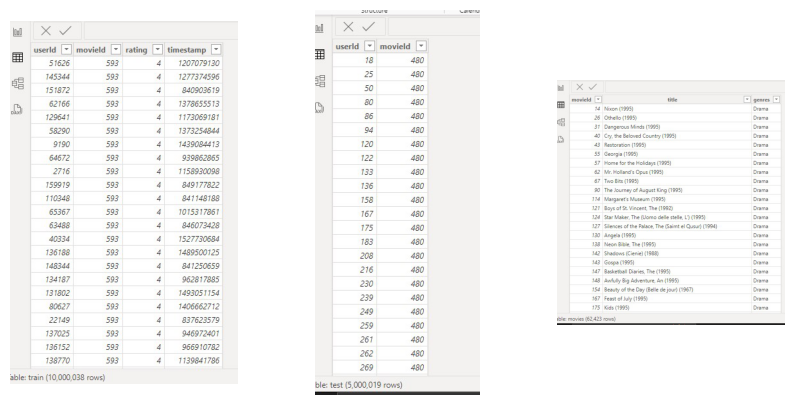

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image

#Image(filename='path/to/image.png')

img = mpimg.imread('screenshot train.jpg')
img2 = mpimg.imread('screenshot test.jpg')
img3 = mpimg.imread('screenshot movies.jpg')
#plt.imshow(img).axis=('off')
#plt.imshow(img2)
#plt.imshow(img3)

# showing some of the Total Data, create a figure and set of subplots element
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

# display image on first subplot
ax[0].imshow(img)
ax[0].axis('off')

# display image on second subplot
ax[1].imshow(img2)
ax[1].axis('off')

# display image on third subplot
ax[2].imshow(img3)
ax[2].axis('off')

# display image
plt.show()

### Why I chose making use of the surprise package?

1. Specialized for Recommender Systems: scikit-surprise is specifically designed for building and evaluating recommender systems, making it highly suited for tasks involving user-item interactions and ratings prediction.

2. Ease of Use: It provides a user-friendly API and simplifies the implementation of various collaborative filtering algorithms, such as matrix factorization, neighborhood methods, and more.

3. Built-in Algorithms: The package includes several built-in algorithms and utilities for training and testing recommendation models, saving time and effort in implementation.

4. Evaluation Metrics: It offers built-in evaluation metrics like RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and others, which are crucial for assessing the performance of recommendation systems.

In [ ]:
# Install the scikit-surprise package for building collaborative filtering models
!pip install scikit-surprise

In [3]:
# Libraries for data handling and analysis
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from time import time
import gc

# Natural Language Processing tools
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

# Machine learning models and evaluation metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD, Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate

# Global settings for reproducibility
random_state = 22 

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


### Explore the Data:

Exploring the data is an important step in any data analysis project, including a movie recommendation project. The goal of data exploration is to gain a better understanding of the data and its characteristics, such as the distribution of values, patterns and relationships between variables, and any anomalies or outliers.

In [4]:
# load the data

train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [6]:
# Preview shape of the train dataset
print(f'The Shape of the data is: {train_set.shape}')
train_set.head()

The Shape of the data is: (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [8]:
# Preview shape of the test dataset
print('The Shape of the data is: ', test_set.shape)
test_set.head()

The Shape of the data is:  (5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [9]:
# checking for null values
print(f'''
Train data
{train_set.isnull().sum()}
''')
print(f'''
Test data
{test_set.isnull().sum()}
''')


Train data
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Test data
userId     0
movieId    0
dtype: int64



In [10]:
# train column dtype check
train_set.info()

# test column dtype check
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [13]:
# checking for null values
print(f'''
Train data
{train_set.nunique()}
''')
print(f'''
Test data
{test_set.nunique()}
''')


Train data
userId        162541
movieId        48213
rating            10
timestamp    8795101
dtype: int64


Test data
userId     162350
movieId     39643
dtype: int64



In [14]:
# group by ratings for visualization
ratings_df = train_set.groupby(['rating']).count()

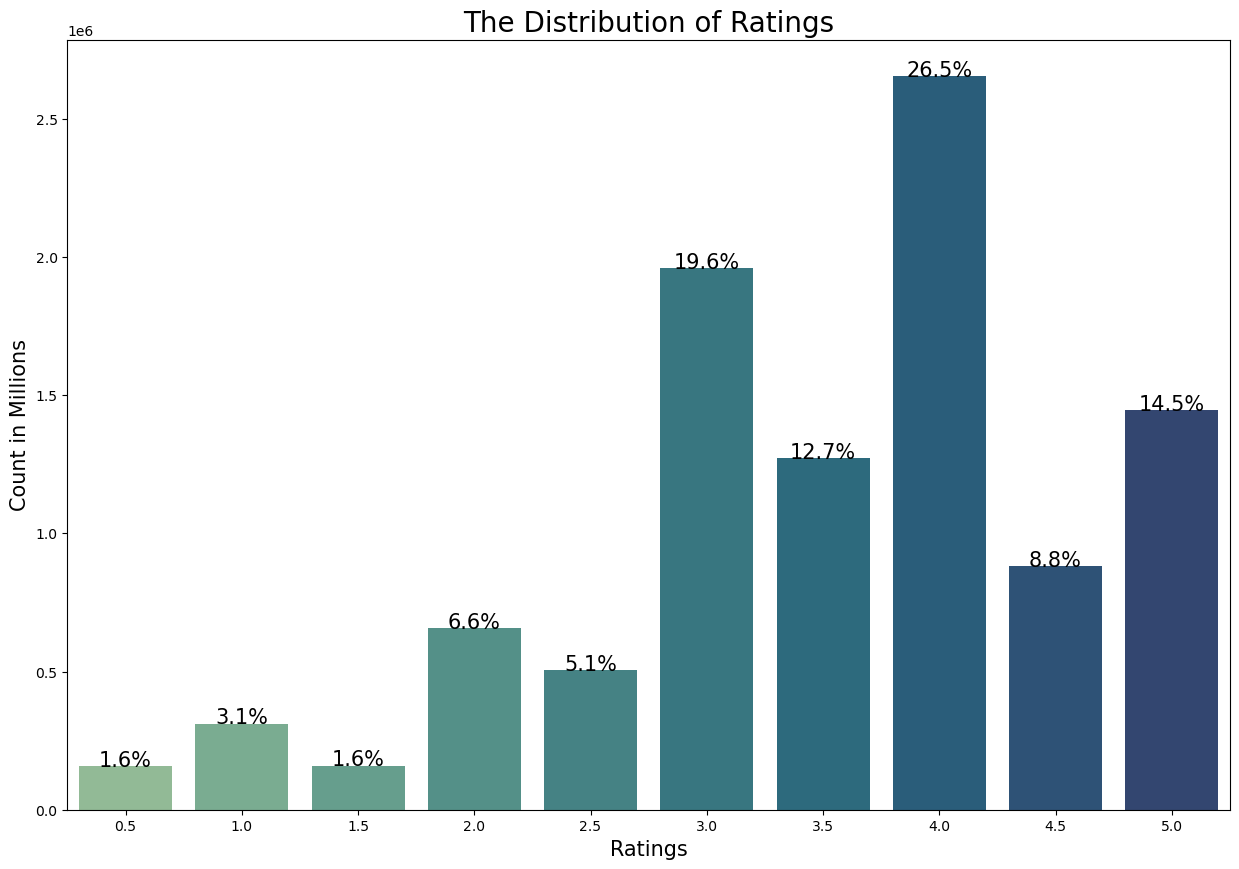

In [15]:
#Plot showing the distribution of counts
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x=ratings_df.index,y='userId',data=ratings_df,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)
a.set_ylabel('Count in Millions',fontsize=15)
a.set_xlabel('Ratings',fontsize=15)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')

plt.show()

In [18]:
ratings_df

,userId,movieId,timestamp
rating,,,
0.5,157571,157571,157571
1.0,311213,311213,311213
1.5,159731,159731,159731
2.0,656821,656821,656821
2.5,505578,505578,505578
3.0,1959759,1959759,1959759
3.5,1270642,1270642,1270642
4.0,2652977,2652977,2652977
4.5,880516,880516,880516


In [19]:
# delete the 'ratings_df' table as it is no longer necessary
del ratings_df

In [20]:
# get the number of unique users in the test set
test_set['userId'].nunique()

162350

In [21]:
# check for users that are in the test set but not in the train set
test_case = test_set['userId'].unique()
train_case = train_set['userId'].unique()
print([id for id in test_case if id not in train_case])

[]


In [22]:
# periodically run to collect and free up memory that is no longer in use.
gc.collect()

673

In [23]:
# Sort train dataset by userId
train_set.sort_values(by=['userId'], inplace= True)
train_set.head()

,userId,movieId,rating,timestamp
6308822,1,296,5.0,1147880044
3137042,1,27721,3.0,1147869115
2533005,1,665,5.0,1147878820
2524478,1,4308,3.0,1147868534
1946297,1,1250,4.0,1147868414


In [24]:
train_set.shape

(10000038, 4)

In [25]:
# Sort test dataset by userId
test_set.sort_values(by=['userId'], inplace= True)
test_set.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [26]:
test_set.shape

(5000019, 2)

In [27]:
# Drop timestamp column for the train dataset
ratings = train_set.drop(columns='timestamp')

# Instanciate a Reader object from surprise package
reader = Reader()
reader = Reader(rating_scale=(1, 5))


# Instanciate the dataset object from surprice package with the ratings table and reader object
data = Dataset.load_from_df(ratings, reader)

The purpose of the code block below is to find the best hyperparameters for the SVD algorithm using a grid search and cross-validation. By trying different combinations of hyperparameters and evaluating the performance of the algorithm on a validation set, we can find the hyperparameters that achieve the best performance. This can help improve the accuracy of our recommendations.

In [ ]:
# Define the parameter grid for SVD
param_grid = {'n_epochs':[15],
              'n_factors':[200, 800],
              'init_std_dev':[0.001, 0.005],
              'random_state': [random_state]}
grid_SVD = GridSearchCV(SVD, cv=2, measures=['rmse'], param_grid=param_grid, n_jobs=-1, joblib_verbose=10)
grid_SVD.fit(data)
print('Best Score is: ')
print(grid_SVD.best_score['rmse'])
print('Best Parameters are: ')
print(grid_SVD.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 55.5min


The RMSE (Root Mean Squared Error) is a measure of the difference between the predicted values and the actual values in a dataset. In the context of a movie recommendation project, the RMSE is used to evaluate the accuracy of the recommendation algorithm by comparing the predicted ratings to the actual ratings given by users.

An RMSE of 0.805 indicates that, on average, the difference between the predicted ratings and the actual ratings is 0.805. This means that the recommendation algorithm is off by an average of 0.805 points on the rating scale (which is typically 1 to 5).

While an RMSE of 0.805 may not be perfect, it is still a relatively good result for a movie recommendation project. It suggests that the algorithm is able to make reasonably accurate predictions about which movies a user will like or dislike. However, there is always room for improvement, and further data exploration and model tuning may help to reduce the RMSE even further.

In [ ]:
#Instantiate an SVD model from the surprice package
svd = SVD(n_epochs=45,n_factors=1000,init_std_dev=0.005,random_state=random_state,verbose=True)

#Instanciate and build the dataset with data object from surprise package
train_data = data.build_full_trainset()

#Train the SVD model
svd.fit(train_data)

In [ ]:
import pickle

model_save_path = "svd_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svd,file)

In [ ]:
model_load_path = "svd_model.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)

In [ ]:
# Extract the userIds and corresponding movieIds into a python list
userId = test['userId'].values.tolist()
movieId = test['movieId'].values.tolist()

# Create a range of numbers which is the size of list created above
count = len(userId)
rating = []
ids = []

# Make rating predictions with the corresponding userIds and movieIds, accessed through indexing
for i in range(count):
    result = svd.predict(userId[i], movieId[i])[3]

    # Store the predicted rating
    rating.append(result)

    # Prepare, save userId and movieId for submission
    ids.append(str(userId[i]) + '_' + str(movieId[i]))

In [ ]:
# Convert ids and ratings to dataframe
test_sub_df =  pd.DataFrame({
        'Id': ids,
        'rating': rating
         })
test_sub_df.head()

In [ ]:
test_sub_df.shape

In [ ]:
# Convert dataframe to csv file for submission.
test_sub_df.to_csv('Kaggle_submission.csv', index=False)